# Classification Model for scI Datasets

This model performs classification on an single-cell immunoblotting (scI) dataset.

We gratefully acknowledge Prof. Jonathan Shewchuk and the teaching assistants of the Spring 2019 offering of UC Berkeley’s CS289A course for helpful discussions and initial code for some of this work.  

## Notebook Initialization

In [ ]:
## Mounting to Google Colab
## Comment out if not using Colab

from google.colab import drive
drive.mount('/content/gdrive')  

## Loading libraries

# Classic libraries
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

# Scikit learn libraries
from skimage import io, transform
from PIL import Image
from sklearn import metrics

# Pytorch libraries
import torch
import torch.nn as nn
from torch.utils import data
import ipdb
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torchsummary import summary



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## File Paths

In [ ]:
# Change this to the working directory
os.chdir('/content/gdrive/experiments')

# Change this to where the data is stored
dataset_path = '/content/gdrive/datasets/'

# Datasets
train_file = dataset_path+'classification_train.csv';
test_file = dataset_path+'classification_test.csv';
val_file = dataset_path+'classification_validate.csv';

# Final model output
model_save_file = 'classification_model.ckpt'; 

## Dataset Loading Functions

In [ ]:
def imgLoad(imagePath):
    '''
    Loads an image using the PIL Image library
    Converts it to int64 and to x-dim * y-dim * 1 
    to make its size compatible with pytorch tensors.
    '''

    image = np.array(Image.open(imagePath)).astype('int64');
    return image

class roiData(data.Dataset):
    ''' Object representing a dataset. Code adapted from
    CS289 HW6 assignment, Spring 2019 offering @ UC Berkeley.

    This object stores an input data file. When called as roidata[i], 
    then the object will return the sample name and label of the ith
    data point.

    NOTE: PyTorch kept having issues with normalization, so it's performed 
    manually.
    '''   
    def __init__(self, label_file, img_load_function, transform=None, dataset_path=None, normalize=None):
        'Initialization'

        self.label_file = label_file
        self.loader = img_load_function
        self.data = pd.read_csv(self.label_file,header=0)[['roiPath','Class']]
        self.transform = transform;
        self.normalize = normalize; 

        # Option to add a path to the image files, if located in some other
        # folder
        if dataset_path is not None:
          sample_header = self.data.columns[0];
          self.data[sample_header] = dataset_path+self.data[sample_header]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self,idx):
        'Generates one sample of data'
        path,label = self.data.iloc[idx]
        label = int(label);
        sample = self.loader(path)

        if self.normalize is not None:
          sample = (sample - self.normalize[0])/self.normalize[1];
        if self.transform is not None:
          sample = self.transform(sample);

        return sample,label



## Normalization

In [ ]:
train_dataset = roiData(train_file,imgLoad,transform=None,dataset_path=dataset_path);

batchSize = 10;
train_loader = data.DataLoader(train_dataset, batch_size = batchSize, shuffle = False, num_workers = 2);

mean = [];
meansq = [];
sample_length = [];

for sample, label in train_loader:
  mean.append(np.mean(np.array(sample)))
  meansq.append(np.mean(np.array(sample**2)))
  sample_length.append(len(label))
  
batch_p = np.array(sample_length)/len(train_dataset);

sample_mean = np.sum(batch_p*np.array(mean));
sample_var = np.sum(batch_p*np.array(meansq)) - (sample_mean ** 2);
sample_std = np.sqrt(sample_var);

print("Sample mean: {}".format(sample_mean))
print("Sample stdev: {}".format(sample_std))

Sample mean: 12158.262775479183
Sample stdev: 8848.8094012705


## Loading Data

In [ ]:
# Dataset transformations for training
train_transform = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.RandomHorizontalFlip()
                                       ]);

# Dataset transformation to turn into a tensor
tensor_transform = transforms.Compose([transforms.ToTensor()]);

# Number of workers
workers = 2; 

# Batch size
batchSize = 16;

train_dataset = roiData(train_file,imgLoad,transform=train_transform,dataset_path=dataset_path,normalize=[sample_mean,sample_std]);
test_dataset = roiData(test_file,imgLoad,transform=tensor_transform,dataset_path=dataset_path,normalize=[sample_mean,sample_std]);
val_dataset = roiData(val_file,imgLoad,transform=tensor_transform,dataset_path=dataset_path,normalize=[sample_mean,sample_std]);

train_loader = data.DataLoader(train_dataset, batch_size = batchSize, shuffle = True, num_workers = workers);
test_loader = data.DataLoader(test_dataset, batch_size = batchSize, shuffle = False, num_workers = workers);
val_loader = data.DataLoader(val_dataset, batch_size = batchSize, shuffle = False, num_workers = workers);


## Model Parameters

In [ ]:
## Model Hyperparameters

## Hyperparameters

# Number of epochs
num_epochs = 25;

# Learning Rate
learning_rate = 5E-6;

# Loss
criterion = nn.CrossEntropyLoss()

# Model
class NeuralNet(nn.Module):
    def __init__(self):
        
        # Defining the model

        super(NeuralNet, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, kernel_size=2, stride = 1, padding=0)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=2, stride = 1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=2, stride = 1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=2, stride = 1)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=2, stride = 1)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout();
        
        self.fc1 = nn.Linear(1280,2048)
        self.fc2 = nn.Linear(2048,4096)
        self.fc3 = nn.Linear(4096,2048)
        self.fc4 = nn.Linear(2048,2)

    def forward(self, x):
        # Forward pass
                
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x));
        x = self.pool2(x);
        x = F.relu(self.conv3(x));
        x = self.pool3(x)
        x = F.relu(self.conv4(x));
        x = self.pool4(x);
        x = F.relu(self.conv5(x));
        x = self.pool5(x);
          
        # FC layers
        x = x.view(-1, np.product(np.array(x.shape[1:]))) 
        x = self.dropout(x);
        x = F.relu(self.fc1(x));
        x = self.dropout(x); 
        x = F.relu(self.fc2(x));
        x = self.dropout(x);
        x = F.relu(self.fc3(x));
        x = self.fc4(x);
        return x

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
model = NeuralNet().to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


## Running the Model

Streaming output truncated to the last 5000 lines.
Training accuracy 93.75 %
Time: 277.38463854789734
Epoch [12/25], Step [185/607], Loss: 0.0144
Training accuracy 100.0 %
Time: 277.59599900245667
Epoch [12/25], Step [190/607], Loss: 0.0057
Training accuracy 100.0 %
Time: 277.7769958972931
Epoch [12/25], Step [195/607], Loss: 0.0283
Training accuracy 100.0 %
Time: 277.9717900753021
Epoch [12/25], Step [200/607], Loss: 0.0144
Training accuracy 100.0 %
Time: 278.1748948097229
Epoch [12/25], Step [205/607], Loss: 0.2043
Training accuracy 93.75 %
Time: 278.3627598285675
Epoch [12/25], Step [210/607], Loss: 0.0432
Training accuracy 100.0 %
Time: 278.5712342262268
Epoch [12/25], Step [215/607], Loss: 0.2250
Training accuracy 93.75 %
Time: 278.7823996543884
Epoch [12/25], Step [220/607], Loss: 0.0230
Training accuracy 100.0 %
Time: 278.9726719856262
Epoch [12/25], Step [225/607], Loss: 0.0533
Training accuracy 100.0 %
Time: 279.1933856010437
Epoch [12/25], Step [230/607], Loss: 0.0521
Trainin

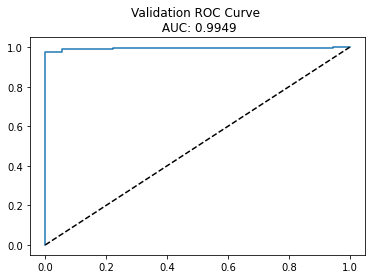

Threshold: 0.0244
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       668
           1       0.53      1.00      0.69        18

    accuracy                           0.98       686
   macro avg       0.76      0.99      0.84       686
weighted avg       0.99      0.98      0.98       686

Starting testing
Testing 5
Testing 10
Testing 15
Testing 20
Testing 25
Testing 30
Testing 35
Testing 40
Testing accuracy 95.3353 %
Testing ROC Curve


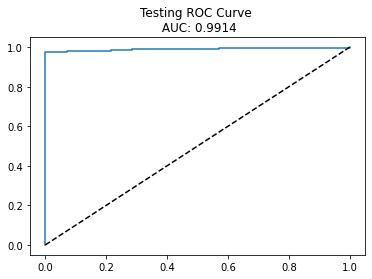

Using Validation Threshold: 0.0244
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       672
           1       0.48      1.00      0.65        14

    accuracy                           0.98       686
   macro avg       0.74      0.99      0.82       686
weighted avg       0.99      0.98      0.98       686



In [ ]:
##################################
#                                #
#          TRAINING              #
#                                #
##################################
 
# Initializing variables
training_loss = [];
training_predictions = [];
training_labels = [];
training_accuracy = [];

print('Beginning training')
total_step = len(train_loader) # To calculate total number of steps. 
start = time.time();

for epoch in np.arange(num_epochs):
  
    # Batch training
    model.train()  
    print('epoch {}'.format(epoch+1))

    for i, (local_batch,local_labels) in enumerate(train_loader):
        local_batch = local_batch.float();

        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)  

        # Forward pass
        outputs = model.forward(local_ims)

        # Loss
        loss = criterion(outputs, local_labels)
        training_loss.append(loss.tolist())

        # Predictions
        _, predicted = torch.max(outputs.data, 1)

        # Accuracy score
        score = metrics.accuracy_score(predicted.cpu().numpy(),local_labels.cpu().numpy());
        training_accuracy.append(score)

        # If last epoch, save the predictions
        if epoch == num_epochs-1:
          training_predictions.extend(predicted);
          training_labels.extend(local_labels); 
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Printing results
        if (i+1) % 5 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            print('Training accuracy {} %'.format(100*score))
            print('Time: '+str(time.time()-start))
    

##################################
#                                #
#          VALIDATION            #
#                                #
##################################
 
model.eval()

val_loss = [];
val_labels = [];
val_pred = [];
val_p = [];

print("Starting validation")
for i, (local_batch,local_labels) in enumerate(val_loader):
    
    # Loading data
    local_batch = local_batch.float();
    local_ims, local_labels = local_batch.to(device), local_labels.to(device)
    
    # Evaluation
    outputs = model.forward(local_ims)

    # Getting probabilities
    val_p.extend(F.softmax(outputs.data,dim=1).cpu().numpy());
    
    # Validation loss
    loss = criterion(outputs, local_labels)
    val_loss.append(loss.tolist())

    # Predictions via max     
    _, predicted = torch.max(outputs.data, 1)
    val_pred.extend(predicted.cpu().numpy())
    val_labels.extend(local_labels.cpu().numpy()) # Don't need this if we never shuffle the validation set, but added for consistency

    if (i+1) % 5 == 0:
      print("Validation "+str(i+1))

  # Accuracy Score
val_score = metrics.accuracy_score(val_pred,val_labels);
print('Validation accuracy {:.4f} %'.format(100 * val_score))

end = time.time()
torch.save(model.state_dict(), model_save_file)

print("Validation ROC Curve")


val_p_zeroclass = np.matrix(val_p)[:,0];

[val_tpr,val_fpr,val_thresholds] = metrics.roc_curve(val_labels,val_p_zeroclass)
plt.plot(val_fpr,val_tpr)
plt.plot(np.linspace(0,1,len(val_tpr)),np.linspace(0,1,len(val_fpr)),'--k')
plt.title("Validation ROC Curve \n AUC: {:.4f}".format(metrics.auc(val_fpr,val_tpr)));
plt.show()

J_threshold = val_thresholds[np.argmax(val_tpr - val_fpr)];
print("Threshold: {:.4f}".format(J_threshold));

val_pred_threshold = np.array(val_p_zeroclass<=J_threshold).astype(int);

print(metrics.classification_report(val_labels,val_pred_threshold)); 


##################################
#                                #
#            TESTING             #
#                                #
##################################
model.eval()

test_labels = [];
test_pred = [];
test_accuracy = [];
test_p = [];

predicted_list = []
groundtruth_list = []
test_p = [];

print("Starting testing")
for i, (local_batch,local_labels) in enumerate(test_loader):


    # Loading data
    local_batch = local_batch.float();
    local_ims, local_labels = local_batch.to(device), local_labels.to(device)
    
    # Model evaluation
    outputs = model.forward(local_ims)

    # Getting probabilities
    test_p.extend(F.softmax(outputs.data,dim=1).cpu().numpy());
    
    # Predictions via max
    _, predicted = torch.max(outputs.data, 1)
    test_pred.extend(predicted.cpu().numpy())
    test_labels.extend(local_labels.cpu().numpy())

    if (i+1) % 5 == 0:
      print("Testing "+str(i+1))

test_score = metrics.accuracy_score(test_pred,test_labels);      
print('Testing accuracy {:.4f} %'.format(100 * test_score))

print("Testing ROC Curve")

test_p_zeroclass = np.matrix(test_p)[:,0];

[test_tpr,test_fpr,test_thresholds] = metrics.roc_curve(test_labels,test_p_zeroclass)
plt.plot(test_fpr,test_tpr)
plt.plot(np.linspace(0,1,len(test_tpr)),np.linspace(0,1,len(test_fpr)),'--k')
plt.title("Testing ROC Curve \n AUC: {:.4f}".format(metrics.auc(test_fpr,test_tpr)));
plt.show()

print("Using Validation Threshold: {:.4f}".format(J_threshold));

test_pred_threshold = np.array(test_p_zeroclass<=J_threshold).astype(int);

print(metrics.classification_report(test_labels,test_pred_threshold)); 